In [ ]:
!git clone https://github.com/Talendar/flappy-bird-gym.git
# Passer le boolean audio_on: bool = False dans 
# flappy-bird-gym/flappy_bird_gym/envs/renderer.py /

Cloning into 'flappy-bird-gym'...
remote: Enumerating objects: 159, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 159 (delta 20), reused 18 (delta 18), pack-reused 135
Receiving objects: 100% (159/159), 65.05 MiB | 48.84 MiB/s, done.
Resolving deltas: 100% (82/82), done.


In [ ]:
!pip install pygame

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 21.8 MB 98.3 MB/s 


In [ ]:
import os

In [ ]:
print(os.getcwd())
os.chdir(os.getcwd() + '/flappy-bird-gym/')
print(os.getcwd())

/content
/content/flappy-bird-gym


In [ ]:
from flappy_bird_gym.envs.flappy_bird_env_rgb import FlappyBirdEnvRGB

In [ ]:
env = FlappyBirdEnvRGB()

In [ ]:
state = env.reset()
print(state.shape)

(288, 512, 3)


# Flappy Bird RGB version for D3QN

In [ ]:
import torch
import torch.nn as nn
import numpy as np
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
from collections import deque
import time
import cv2
from torch.utils.tensorboard import SummaryWriter

In [ ]:
env = FlappyBirdEnvRGB()

## Image pre processing

In [ ]:
state = env.reset()
print(state.shape)

(288, 512, 3)


As you can see, the state contains 288x512x3 values. Therefor, we will use conv layers to deal with these values.

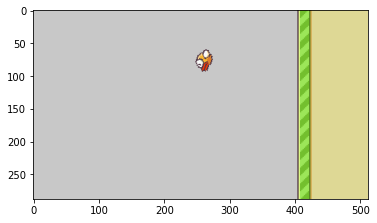

In [ ]:
plt.figure()
plt.imshow(state)

Here is the pic of the RGB state's representation

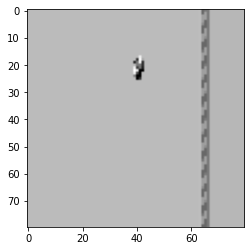

In [ ]:
state_converted = cv2.cvtColor(cv2.resize(state, (80, 80)), cv2.COLOR_BGR2GRAY)
plt.figure()
plt.imshow(state_converted, cmap='gray')

Here is the pic of the gray state's representation redimentioned with 80x80 .

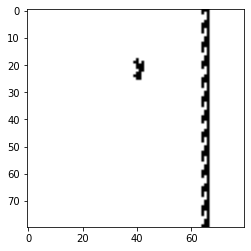

In [ ]:
state_converted = cv2.adaptiveThreshold(state_converted,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv2.THRESH_BINARY,11,2)
plt.figure()
plt.imshow(state_converted, cmap='gray')

In [ ]:
def test(q_network) :
    
    state = env.reset()
    done = False
    cum_sum = 0
    while not done :
        state_t = torch.as_tensor(state , dtype = torch.float32,device = device).unsqueeze(0)
        action = torch.argmax(q_network(state_t)).item()
        new_state,reward,done,_ = env.step(action)
        state = new_state
        cum_sum += reward
        
    return cum_sum

In [ ]:
"""
Dueling Deep Q Network
"""

class DuelingQNetwork(nn.Module) :
    """
    Implementation de la classe Dueling DQN
    """

    def __init__(self,
        nb_actions : int
    ) : 
        
        super().__init__()
        self.nb_actions = nb_actions 

        # Linear -> ReLU -> Linear -> ReLU -> Linear
        self.net =  nn.Sequential(
            nn.Conv2d(4,32,8,stride = 4,padding=(0,0)),
            nn.MaxPool2d(kernel_size=2 , padding=(0,0)),
            nn.ReLU(),
            nn.Conv2d(32,64,4,stride = 2 , padding = (1,1)),
            nn.Dropout2d(),
            nn.MaxPool2d(kernel_size=2, stride = 2,padding = (1,1)),
            nn.ReLU(),
            nn.Conv2d(64,64,3,stride = 1, padding = (1,1)),
            nn.Dropout2d(),
            nn.MaxPool2d(kernel_size=2, padding = (1,1)),
            nn.Flatten(),
            nn.Linear(256, 256),
        )

        # implementation pour la fonction avantage 
        # correspond a la sortie avantage du réseau de neurones
        self.net_advantage = nn.Sequential(
            nn.ReLU(),
            nn.Linear(256, self.nb_actions)
        )

        # implementation pour la value function  
        # correspond a la sortie value function du réseau de neurones
        self.net_state_value = nn.Sequential(
            nn.ReLU(),
            nn.Linear(256,1)
        )
        
    def advantage(self,x) :
        return self.net_advantage(self.net(x))
    
    def state_value(self,x) :
        return self.net_state_value(self.net(x))
    
    def forward(self,x) :
        return self.state_value(x) + self.advantage(x) - torch.mean(self.advantage(x),dim=1).unsqueeze(1)

In [ ]:
class TrainModel :
    """
    Class for training our D3QN Model
    """
    def __init__(self,
        nb_episode : int,
        discount_factor : float,
        learning_rate : float,
        test_frequency : int,
        nb_tests_iteration : int,
        epsilon_decay : float,
        epsilon_min : float,
        batch_size : int,
        size_replay_buffer : int,
        update_frequency : int,
        tau : float,
        device
    ) :
        
        """
        HYPER PARAMETERS
        """
        
        self.nb_episode = nb_episode # nombre d'episode d'entrainement
        self.discount_factor = discount_factor # facteur d'actualisation
        self.learning_rate = learning_rate # taux d'apprentissage
        self.test_frequency = test_frequency # periode de test
        self.nb_tests_iteration = nb_tests_iteration # periode d'affichage des tests
        self.epsilon_decay = epsilon_decay # entre [0,1] coeficient multiplicateur de epsilon
        self.epsilon_min = epsilon_min # valeur min de epsilon, jusqua combien elle peut diminuer
        self.epsilon = 1.0 
        self.batch_size = batch_size # taille du sous ensemble du replay buffer
        self.size_replay_buffer = size_replay_buffer # taille du replay buyffer
        self.update_frequency = update_frequency # periode de mise a jour du target network
        self.tau = tau # facteur de synchronisation
        
        self.writer = SummaryWriter("./logs/d3qn_flappy_bird_rgb_rewards")
        
        
        """
        QNETWORK, QTARGETNETWORK AND BESTMODEL
        """
        self.device = device

        self.q_network , self.q_target_network, self.best_model = self.initialisation_q_networks() # initialisation et copie du q_network
        self.best_value = -1e10
        
        """
        TESTING
        """
        self.list_mean_rewards = list() 
        self.list_std_rewards = list()
        
    def initialisation_q_networks(self) :
        """
        return :
            q_network : DuelingQNetwork
            q_target_network : DuelingQNetwork
            best_model : DuelingQNetwork
        """
        # initialisation des réseaux de neurones

        q_network = DuelingQNetwork(
            nb_actions = nb_actions
        ).to(self.device)
        
        q_target_network = DuelingQNetwork(
            nb_actions = nb_actions
        ).to(self.device)
        
        best_model = DuelingQNetwork(
            nb_actions = nb_actions
        ).to(self.device)
        
        """ q_network copy """
        q_target_network.load_state_dict(q_network.state_dict())
        best_model.load_state_dict(q_network.state_dict())

        # on utilise comme optimizer Adam (a tester avec d'autres) 
        self.optimizer = torch.optim.Adam(q_network.parameters(), lr=self.learning_rate) 
        
        return q_network , q_target_network, best_model
        
        
    def pre_processing(self,state,old_frame = None) : 
        """
            input : np.array : 
            return : torch.tensor : 
        """
        if old_frame is None : 
            state_converted = cv2.cvtColor(cv2.resize(state, (80, 80)), cv2.COLOR_BGR2GRAY)
            state_stacked = np.stack((state_converted, state_converted, state_converted, state_converted), axis=2)
            state_t = torch.as_tensor(state_stacked , device = self.device, dtype = torch.float32).unsqueeze(0).transpose(3 , 1)
        else :
            new_state_converted = cv2.cvtColor(cv2.resize(state, (80, 80)), cv2.COLOR_BGR2GRAY)
            new_state_converted = new_state_converted.reshape(new_state_converted.shape[0],new_state_converted.shape[1],1 )
            state_stacked = np.append(new_state_converted, old_frame[:, :, :3], axis = 2)
            state_t = torch.as_tensor(state_stacked , device = self.device, dtype = torch.float32).unsqueeze(0).transpose(3 , 1)
            
        return state_stacked,state_t
        
        
    def training(self) :
        
        start_time = time.time()
        replay_buffer = deque(maxlen=self.size_replay_buffer) # on utilise une file 
        timestep = 0
        
        env = FlappyBirdEnvRGB()
        
        for episode in range(self.nb_episode) :
            state = env.reset()
            state,state_t = self.pre_processing(state)
            done = False
            cumul = 0 # reward total
            
            self.epsilon = max(self.epsilon * self.epsilon_decay,self.epsilon_min)
    
            while not done : 
                
                # epsilon-greedy pour la selection de l'action 
                if random.random() > self.epsilon : 
                    action = torch.argmax(self.q_network(state_t)).item()
                else :
                    action = env.action_space.sample()
            
                new_state,reward,done,_ = env.step(action)

                new_state_stacked,new_state_t = self.pre_processing(new_state,state)
                
                cumul += reward
                
                transition = (state_t,action,done,reward,new_state_t) # a ajouter dans le replay buffer
                replay_buffer.append(transition)

                if len(replay_buffer) >= self.batch_size and timestep % self.update_frequency == 0 :
                    
                    # selection du batch aleatoirement
                    batch = random.sample(replay_buffer,self.batch_size)

                    # transformation en tensor
                    
                    states = [exp[0] for exp in batch]
                    actions = np.asarray([exp[1] for exp in batch],dtype=int)
                    dones = np.asarray([exp[2] for exp in batch],dtype=int)
                    rewards = np.asarray([exp[3] for exp in batch],dtype=np.float32)
                    new_states = [exp[4] for exp in batch]
                    
                    states_t = torch.stack(states).squeeze(1)
                    new_states_t = torch.stack(new_states).squeeze(1)

                    # states_t = torch.as_tensor(states , dtype=torch.float32, device = self.device)
                    dones_t = torch.as_tensor(dones , dtype = torch.int64, device = self.device).unsqueeze(1)
                    # new_states_t = torch.as_tensor(new_states , dtype=torch.float32, device = self.device)
                    actions_t = torch.as_tensor(actions , dtype = torch.int64, device = self.device).unsqueeze(1)
                    rewards_t = torch.as_tensor(rewards , dtype=torch.float32, device = self.device).unsqueeze(1)

                    # l'esperance des futurs rewards
                    y_target = (rewards_t + 
                                self.discount_factor * 
                                (1 - dones_t) * 
                                torch.gather(self.q_target_network(new_states_t),dim=1,index=torch.argmax(self.q_network(new_states_t),dim=1).unsqueeze(1)).detach())

                    # descente de gradient 
                    mse = nn.MSELoss()
                    loss = mse(torch.gather(self.q_network(states_t),dim=1,index=actions_t), y_target)
                    self.optimizer.zero_grad()
                    loss.backward()
                    self.optimizer.step()
                    self.update_q_target_network()

                timestep += 1
                state = new_state_stacked
                state_t = new_state_t
            
            # Partie Test
            if episode % self.test_frequency == 0 :
                
                mean_rewards, std_rewards = self.testing()
                
                self.list_mean_rewards.append( mean_rewards )
                self.list_std_rewards.append( std_rewards )
                
                end_time = time.time()
                diff_time = end_time - start_time
                start_time = time.time()
                """
                Keep the best model
                """
                if mean_rewards > self.best_value :
                    self.best_value = mean_rewards
                    self.best_model.load_state_dict(self.q_network.state_dict())
                
                """
                display :
                """
                self.writer.add_scalar('TP3 : rewards FlappyBird', mean_rewards, episode)
                print(f"({(episode/self.nb_episode*100)}%) - Episode : {episode} - mean rewards : {mean_rewards} - std rewards : {std_rewards} - eps : {self.epsilon} - time : {diff_time}s - best value : {self.best_value}")
        
        
    def update_q_target_network(self) : 
        """ update du q-target en fonction du tau"""   
        for target_param, local_param in zip(self.q_target_network.parameters(), self.q_network.parameters()):
            target_param.data.copy_(self.tau*local_param.data + (1.0-self.tau)*target_param.data)  
        
        
    def testing(self) :
        """
            return :
                list_cum_sum.mean : float
                list_cum_sum.std : float
        """
        list_cum_sum = list()
        for i in range(self.nb_tests_iteration) :
            list_cum_sum.append(self.one_test_model())
            
        list_cum_sum = np.asarray(list_cum_sum , dtype=np.float32)    
        
        return list_cum_sum.mean(), list_cum_sum.std()
    
            
    def one_test_model(self) :
        """
            return :
                cum_sum : float (reward of an episode with the current q_network)
        """
        random.seed(10)
        
        env = FlappyBirdEnvRGB()
        
        state = env.reset()
        state,state_t = self.pre_processing(state)
        done = False
        cum_sum = 0.0
        while not done :
            action = torch.argmax(self.q_network(state_t)).item()
            new_state,reward,done,_ = env.step(action)
            new_state_stacked,new_state_t = self.pre_processing(new_state,state)
            
            state = new_state_stacked
            state_t = new_state_t
            cum_sum += reward
                
        return cum_sum
    
    def save_best_model(self) :
        path = "best_model_d3qn_lunarlanderdiscret" + str(self.best_value)
        torch.save(self.best_model.state_dict(),path)

## Hyper-parameters

In [ ]:
device = torch.device("cpu") # torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"device used {device}")
nb_episode = 10000000
discount_factor = 0.99
learning_rate = 0.0003
test_frequency = 10
nb_tests_iteration = 10
epsilon_decay = 0.995
epsilon_min = 0.01
epsilon = 1.0
batch_size = 64
size_replay_buffer = 50000
update_frequency = 1
tau = 1e-3

device used cpu


## Initialisation

In [ ]:
nb_actions = 2

train_model = TrainModel(
      nb_episode = nb_episode,
      discount_factor = discount_factor,
      learning_rate = learning_rate,
      test_frequency = test_frequency,
      nb_tests_iteration = nb_tests_iteration,
      epsilon_decay = epsilon_decay,
      epsilon_min = epsilon_min,
      batch_size = int(batch_size),
      size_replay_buffer = size_replay_buffer,
      update_frequency = update_frequency,
      tau = tau,
      device = device
)

In [ ]:
train_model.training()

(0.0%) - Episode : 0 - mean rewards : 101.0 - std rewards : 0.0 - eps : 0.995 - time : 11.373182773590088s - best value : 101.0
(9.999999999999999e-05%) - Episode : 10 - mean rewards : 101.0 - std rewards : 0.0 - eps : 0.946354579813443 - time : 190.39256405830383s - best value : 101.0
(0.00019999999999999998%) - Episode : 20 - mean rewards : 101.0 - std rewards : 0.0 - eps : 0.9000874278732445 - time : 189.4466164112091s - best value : 101.0
(0.00030000000000000003%) - Episode : 30 - mean rewards : 101.0 - std rewards : 0.0 - eps : 0.8560822709551227 - time : 189.17620968818665s - best value : 101.0
(0.00039999999999999996%) - Episode : 40 - mean rewards : 101.0 - std rewards : 0.0 - eps : 0.8142285204175609 - time : 189.51159286499023s - best value : 101.0
(0.0005%) - Episode : 50 - mean rewards : 101.0 - std rewards : 0.0 - eps : 0.7744209942832988 - time : 196.52842450141907s - best value : 101.0
(0.0006000000000000001%) - Episode : 60 - mean rewards : 101.0 - std rewards : 0.0 - e

In [ ]:
train_model.save_best_model()